# Yelp Data

In [1]:
from __future__ import print_function

import argparse
import geopandas as gpd
import json
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import pprint
import pylab as pl
import requests
import shutil 
import sys
import urllib
import urllib.request 
import zipfile 
%matplotlib inline

try:
    # For Python 3.0 and later
    from urllib.error import HTTPError
    from urllib.parse import quote
    from urllib.parse import urlencode
except ImportError:
    # Fall back to Python 2's urllib2 and urllib
    from urllib2 import HTTPError
    from urllib import quote
    from urllib import urlencode
    
from pandas.io.json import json_normalize
from shapely.geometry import Point

In [2]:
# Constants for accessing the API
API_KEY = open('yelp_api.txt', 'r').readlines()[1][:-1] # api stored in seperate .txt file
API_HOST = 'https://api.yelp.com'
SEARCH_PATH = '/v3/businesses/search'
BUSINESS_PATH = '/v3/businesses/'

### Search Terms
params = {
    'term': 'coffee',
    'location': 'Clinton Hill, Brooklyn',
    'limit':'50'
}

In [3]:
def request(host=API_HOST, path=SEARCH_PATH, api_key=API_KEY, url_params=params):
    """Given your API_KEY, send a GET request to the API.
    Args:
        host (str): The domain host of the API.
        path (str): The path of the API after the domain.
        API_KEY (str): Your API Key.
        url_params (dict): An optional set of query parameters in the request.
    Returns:
        dict: The JSON response from the request.
    Raises:
        HTTPError: An error occurs from the HTTP request.
    """
    url_params = url_params or {}
    url = '{0}{1}'.format(host, quote(path.encode('utf8')))
    headers = {
        'Authorization': 'Bearer %s' % api_key,
    }

    response = requests.request('GET', url, headers=headers, params=url_params)

    return response.json()

In [4]:
def search(api_key, term, location, categories, offset, price):
    """Query the Search API by a search term and location.
    Args:
        term (str): The search term passed to the API.
        location (str): The search location passed to the API.
    Returns:
        dict: The JSON response from the request.
    """

    url_params = {
        'term': term.replace(' ', '+'),
        'location': location.replace(' ', '+'),
        'limit': int(params['limit']),
        'offset': offset,
        'categories': categories,
        'price':price
    }
    
    find_locs = request(API_HOST, SEARCH_PATH, api_key, url_params=url_params)
    
    return json_normalize(find_locs['businesses'])

In [5]:
# don't really need this, but useful for initially analyzing the pulls from yelp
def print_pretty_yelp_json(json):
    for i in range(len(json['businesses'])):
        item = json['businesses'][i] #['alias']

        print(' Store Name:',item['name'], '\n',
              'Categories:', [item['categories'][i]['title'] \
                              for i in range(len(item['categories']))], '\n',
              'Latitude:', item['coordinates']['latitude'], '\n',
              'Longitude:', item['coordinates']['longitude'], '\n',
              'City:', item['location']['city'], '\n',
              'Zip Code:', item['location']['zip_code'], '\n',
              'Price:', item['price'],  '\n',
              'Rating:', item['rating'], '\n',
              'Review Count:', item['review_count'], '\n')

In [6]:
def filtered_coffee(df):
    category_list = [[df['categories'][j][i]['title'] \
    for i in range(len(df['categories'][j]))] \
    for j in range(len(df['categories']))]

    location = list(zip(df['coordinates.latitude'], 
                             df['coordinates.longitude']))

    columns = ['Store_Name', 'Categories', 'Location', 'City', 
                   'Zip_Code', 'Price', 'Rating', 'Review_Count']
    data = [list(df['name']), category_list, location, list(df['location.city']),
                list(df['location.zip_code']), list(df['price']), list(df['rating']), 
                list(df['review_count'])]


    filtered_coffee = pd.DataFrame(data = dict(zip(columns, data)))
    filtered_coffee = filtered_coffee[columns]
    return filtered_coffee

In [7]:
def find_coffee(search_term='coffee', loc='Brooklyn',category=None, loops=20, price=[1,2,3,4]):
    
    coffee_shops_df = None
    
    for i in range(loops):
        try:
            # max api allows is 50 per pull
            coffee_results = search(API_KEY, search_term, loc, category, i*50, price)
        except IndexError:
            # error raised once no more coffee shops in the area are found.
            for j in range(49, -1, -1): 
                if j == 0:
                    break
                try:
                    coffee_results = search(API_KEY, search_term, loc, category, i*j, price)
                except IndexError:
                    continue
                break
            
        coffee_results = filtered_coffee(coffee_results)
        
        if isinstance(coffee_shops_df, pd.DataFrame):
            coffee_shops_df = pd.concat([coffee_shops_df, coffee_results])
            coffee_shops_df.reset_index(drop=True, inplace=True)
        else:
            coffee_shops_df = coffee_results
            
    return coffee_shops_df

In [8]:
def pd_to_gpd(df):
    geom = df.apply(lambda x: Point(x['Location'][1], x['Location'][0]), axis=1)
    geo_df = gpd.GeoDataFrame(df, geometry=geom)
    geo_df.crs = {'init' :'epsg:4326'}
    return geo_df

# Zillow Data

In [9]:
def create_zillow_map(city):
    '''
    Takes the name of a city as an arguement, and pulls the file from Zillow's neighborhood website
    Returns a geopandas dataframe of the city
    '''
    
    state = cities_to_states[city]

    zillow_call = 'https://www.zillowstatic.com/static-neighborhood-boundaries' + \
                  '/LATEST/static-neighborhood-boundaries/shp/' + \
                  'ZillowNeighborhoods-{}.zip'.format(state)

    file_name = '{}_shape.zip'.format(state)
    city_shp = 'ZillowNeighborhoods-{}.shp'.format(state)

    # download the file if it doesn't already exist
    if not os.path.exists(city_shp):
        # download zip from Zillow website
        with urllib.request.urlopen(zillow_call) as response, \
                           open(file_name, 'wb') as out_file:
            shutil.copyfileobj(response, out_file)
        # extract shapefile into current folder
        with zipfile.ZipFile(file_name,"r") as zip_ref:
            zip_ref.extractall()
        # remove unneeded files
        os.remove(file_name)

    data = gpd.read_file(city_shp)
    if city != 'Boston':
        data = data[data['City']==city]
    elif city == 'Boston':
        data = data[(data['City']==city) | (data['City']=='Cambridge') \
                    | (data['City']=='Newton')]
        
    data.crs = {'init' :'epsg:4326'}
    
    return data

In [10]:
# cities to work with
cities_to_states = {'New York':'NY',
                    'Los Angeles': 'CA', 
                    'Chicago':'IL',
                    'Dallas': 'TX',
                    'Houston':'TX',
                    'Washington':'DC',
                    'Philadelphia': 'PA',
                    'Miami': 'FL',
                    'Atlanta': 'GA',
                    'Boston':'MA', 
                    'San Francisco':'CA',
                    'Detroit': 'MI',
                    'Denver': 'CO',
                    'Charlottesville': 'VA',
                    'Baltimore': 'MD',
                    'Charlotte': 'NC',
                    'Pittsburgh': 'PA',
                    'Austin': 'TX',
                    'Cleveland': 'OH',
                    'Columbus': 'OH',
                    'Portland': 'OR',
                    'New Orleans': 'LA',
                    'Salt Lake City': 'UT',
                    'Seattle':'WA'}

cities = sorted(list(cities_to_states.keys()))

In [11]:
def print_cities(cities):
    import math
    # print maps of all of the cities
    ncols = 2
    nrows = math.ceil(len(cities)/ncols)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize = (16, 100))
    for i in range(len(cities)):
        city_gdf = create_zillow_map(cities[i])
        ax = plt.subplot(nrows, ncols,i+1)
        city_gdf.plot(figsize=(8,8), color='lightblue', edgecolor='k', ax=ax)
        ax.set_title(cities[i], fontsize=14, weight='bold')
    return

# Bringing it all together

In [12]:
def merge_gdfs(city, loops=20):
    
    if city == 'Washington':
        city_temp = 'Washington, DC'
    else:
        city_temp = city
    
    coffee_shops_df = find_coffee(loc=city_temp, loops=loops)
    coffee_shops_gdf = pd_to_gpd(coffee_shops_df)
    city_map_gdf = create_zillow_map(city)
    merged_gdf = gpd.sjoin(coffee_shops_gdf, city_map_gdf, op='within')
    
    # do some cleaning and group bys
    merged_gdf.rename(columns={'City_right':'City'}, inplace=True)
    merged_gdf.drop(['index_right', 'City_left'], axis=1, inplace=True)
    merged_gdf.reset_index(drop=True, inplace=True)
    city_map_gdf.reset_index(drop=True, inplace=True)
    
    # central coordinates for neighborhood labels
    city_map_gdf['coords'] = city_map_gdf['geometry'].apply(lambda x: x.representative_point().coords[:])
    city_map_gdf['coords'] = [coords[0] for coords in city_map_gdf['coords']]
    
    # add count of coffee shops in each neighborhood to map df
    neighborhood_counts = dict(merged_gdf.groupby('Name').count().iloc[:,0])
    city_map_gdf['count'] = city_map_gdf.Name.map(neighborhood_counts)\
                                        .fillna(0) \
                                        .astype(int)
    
    # add mean rating to map df
    rating_mean = dict(merged_gdf.groupby('Name').mean()['Rating'])
    city_map_gdf['mean_rating'] = city_map_gdf.Name.map(rating_mean)\
                                              .round(3)
    
    # add mean price to map df
    price_map = {'$': 1, '$$': 2, '$$$': 3, '$$$$': 4}
    merged_gdf['price_int'] = merged_gdf.Price.map(price_map)
    price_mean = dict(merged_gdf.groupby('Name').mean()['price_int'])
    city_map_gdf['mean_price'] = city_map_gdf.Name.map(price_mean)\
                                             .round(3)

    # add review count to map df
    total_reviews = dict(merged_gdf.groupby('Name').mean()['Review_Count'])
    city_map_gdf['review_count'] = city_map_gdf.Name.map(total_reviews)\
                                               .fillna(0) \
                                               .astype(int) 
    
    # indentify 'chain' coffee stores as those with > 3 location in a city
    # add percentage of stores that are chain for each neighborhood to map df
    chain = dict(merged_gdf['Store_Name'].value_counts() > 3)
    merged_gdf['chain'] = merged_gdf.Store_Name.map(chain)
    pct_chain = dict(merged_gdf.groupby('Name').mean()['chain'])
    city_map_gdf['pct_chain'] = city_map_gdf.Name.map(pct_chain)\
                                                 .astype(float)\
                                                 .round(3)
     
    # identify those shops that only have the category 'Coffee & Tea'
    strictly_coffee = [('Coffee & Tea' in cat and len(cat) == 1) or \
                       ('Cafes' in cat and len(cat) == 1) or \
                       ('Coffee Roasteries' in cat and len(cat) == 1) or \
                       ('Coffee & Tea' in cat and 'Cafes' in cat and len(cat) == 2) or \
                       ('Coffee & Tea' in cat and 'Coffee Roasteries' in cat and len(cat) == 2) or \
                       ('Cafes' in cat and 'Coffee Roasteries' in cat and len(cat) == 2) or \
                       ('Coffee & Tea' in cat and 'Cafes' in cat and 'Coffee Roasteries' in cat and len(cat) == 3) \
                       for cat in merged_gdf.Categories.values]
    merged_gdf['strictly_coffee'] = strictly_coffee
    
    # indentifies weather 'Coffee & Tea' is a category (regardless of if there are others)
    coffee_is_cat = ['Coffee & Tea' in cat or 'Cafes' in cat or 'Coffee Roasteries' in cat \
                     for cat in merged_gdf.Categories.values]
    merged_gdf['coffee_is_cat'] = coffee_is_cat # meow
    
    # add bool columns for other notable categories
    merged_gdf['breakfast_and_brunch'] = ['Breakfast & Brunch' in cat for cat in merged_gdf.Categories.values]
    merged_gdf['bakeries'] = ['Bakeries' in cat for cat in merged_gdf.Categories.values]
    merged_gdf['diner'] = ['Diner' in cat for cat in merged_gdf.Categories.values]
    merged_gdf['deli'] = ['Deli' in cat for cat in merged_gdf.Categories.values]
    merged_gdf['ice_cream_and_froyo'] = ['Ice Cream & Frozen Yogurt' in cat for cat in merged_gdf.Categories.values]
    merged_gdf['juice_and_smoothie'] = ['Juice Bars & Smoothies' in cat for cat in merged_gdf.Categories.values]
    
    # identify primary category of shop, and add a categorical column for it
    def categorize(x):
        '''
        fa la la la la
        '''
        cat_start = x.index.get_loc('chain')
        cat_cols  = x[cat_start:]
        if cat_cols['chain'] == True:
            return 'chain'
        elif cat_cols['diner'] == True:
            return 'diner'
        elif cat_cols['deli'] == True:
            return 'deli'
        elif cat_cols['ice_cream_and_froyo'] == True:
            return 'ice_cream_and_froyo'
        elif cat_cols['juice_and_smoothie'] == True:
            return 'juice_and_smoothie'
        elif cat_cols['bakeries'] == True:
            return 'bakeries'
        elif cat_cols['breakfast_and_brunch'] == True:
            return 'breakfast_and_brunch'
        elif cat_cols['strictly_coffee'] == True:
            return 'strictly_coffee'
        else:
            return 'other'       
    
    merged_gdf['primary_category'] = merged_gdf.apply(lambda x: categorize(x), axis=1)
    
    # add percentage of our just-defined categories to our map df
    cat_start = merged_gdf.columns.get_loc("strictly_coffee")
    categories = merged_gdf.columns[cat_start:-1]
    for cat in categories:
        city_map_gdf['pct_' + str(cat)] = city_map_gdf.Name.map(dict( \
                          merged_gdf.groupby('Name').mean()[cat])).round(3)

    return city_map_gdf, merged_gdf

In [13]:
def print_top(city_name, df, count=10):
    print('----------------------------------------')
    print('Top {} Categories for {}:'.format(count, city_name))
    print('-----------------------' + '-' * len(city_name))
    print(pd.Series([x for y in df.Categories.values for x in y]).value_counts()[:count])
    print('----------------------------------------')

In [14]:
def plot_map(map_gdf, data_gdf, column='count', neighborhood_labels=True):
    vmin, vmax = map_gdf[column].min(), map_gdf[column].max()
    fig, ax = plt.subplots(1, figsize=(18.2,15.5))
    base = map_gdf.plot(ax=ax, column='count', edgecolor='white', 
                        cmap='copper', vmin=vmin, vmax=vmax, legend=True)
    data_gdf.plot(ax=base, marker="o", color='r',
                              markersize=10, alpha=0.7)
        # add neighborhood labels
    if neighborhood_labels == True:
        for idx, row in map_gdf.iterrows():
            plt.annotate(s=row['Name'], xy=row['coords'], color='white',
                         horizontalalignment='center', size=8)
    ax.set_title("Coffee Shops in " + str(city), size=20)
    plt.show()
    
#plot_map(city_map_gdf, merged_gdf, 'count')

In [15]:
path = 'coffee_data/'

def save_files(list_of_cities, update_data=False):
    for city in list_of_cities:
        # if the file exists, and we don't want to update data, skip files already downloaded
        # so that we can speed things up.
        if not os.path.isdir(path):
            os.mkdir(path)
        if not os.path.isfile(path + str(city) + '/{}_map.csv'.format(city)) or update_data == True:
        
            # run main script
            city_map_gdf, merged_gdf = merge_gdfs(city)

            #print top 10 categories for each, just for the heck of it
            print_top(city, merged_gdf, 10)
            print()

            # save to folder
            if not os.path.isdir(path + str(city)):
                os.mkdir(path + str(city))
            city_map_gdf.geometry.to_file(path + str(city) + '/map_geo_{}.shp'.format(city))
            map_df = pd.DataFrame(city_map_gdf.values, columns=city_map_gdf.columns)
            map_df.to_csv(path + str(city) + '/{}_map.csv'.format(city), encoding='utf-8', index=False)
            merged_gdf.geometry.to_file(path + str(city) + '/data_geo_{}.shp'.format(city))
            data_df = pd.DataFrame(merged_gdf.values, columns=merged_gdf.columns)
            data_df.to_csv(path + str(city) + '/{}_data.csv'.format(city), encoding='utf-8', index=False)
               
        else:
            print(str(city) + ' is already saved as a file.')

In [16]:
def read_in_data(city):
    '''
    reads in files
    '''
    path             = 'coffee_data/'
    crs              = {'init': 'epsg:4326'}
    
    def lon_lat_str_to_tuple(string):
        '''
        because coords are converted from tuple to string when 
        '''
        string = string.split(', ')
        lon = float(string[0].split('(')[1])
        lat = float(string[1].split(')')[0])
        return (lon, lat)
    
    # read in map
    map_df           = pd.read_csv(path + str(city) + '/{}_map.csv'.format(city))
    map_df_geo       = gpd.read_file(path + str(city) + '/map_geo_{}.shp'.format(city))
    map_df.geometry  = map_df_geo.geometry
    map_gdf          = gpd.GeoDataFrame(map_df, crs=crs, geometry=map_df.geometry)
    map_gdf.coords   = map_gdf.coords.apply(lambda x: lon_lat_str_to_tuple(x))
    
    # read in data
    data_df          = pd.read_csv(path + str(city) + '/{}_data.csv'.format(city))
    data_df_geo      = gpd.read_file(path + str(city) + '/data_geo_{}.shp'.format(city))
    data_df.geometry = data_df_geo.geometry
    data_gdf         = gpd.GeoDataFrame(data_df, crs=crs, geometry=data_df.geometry)

    return map_gdf, data_gdf

In [17]:
def megalist(list_of_cities):
    
    if len(list_of_cities) == 0:
        print('no cities provided')
        return
    
    # make base dfs
    if not os.path.isfile(path + str(list_of_cities[0]) + '/{}_map.csv'.format(list_of_cities[0])):
        save_files([list_of_cities[0]])
    mega_map, mega_data = read_in_data(list_of_cities[0])
    
    if len(list_of_cities) == 1:
        return mega_map, mega_data
    
    for city in list_of_cities[1:]:
        if not os.path.isfile(path + str(city) + '/{}_map.csv'.format(city)):
            save_files([city])
        temp_map, temp_data = read_in_data(city)
        mega_map  = gpd.GeoDataFrame(pd.concat([mega_map, temp_map], ignore_index=True))
        mega_data = gpd.GeoDataFrame(pd.concat([mega_data, temp_data], ignore_index=True))
        
    if not os.path.isdir(path + 'COFFEE'):
        os.mkdir(path + 'COFFEE')
    # save map data
    mega_map.geometry.to_file(path + 'COFFEE' + '/map_geo_{}.shp'.format(city))
    map_df = pd.DataFrame(mega_map.values, columns=mega_map.columns)
    map_df.to_csv(path + 'COFFEE' + '/{}_map.csv'.format('COFFEE'), encoding='utf-8', index=False)
    # save store data
    mega_data.geometry.to_file(path + 'COFFEE' + '/data_geo_{}.shp'.format(city))
    data_df = pd.DataFrame(mega_data.values, columns=mega_data.columns)
    data_df.to_csv(path + 'COFFEE' + '/{}_data.csv'.format('COFFEE'), encoding='utf-8', index=False)
    
    return mega_map, mega_data

In [19]:
mega_map, mega_data = megalist(cities)

In [20]:
mega_data.head()

,Store_Name,Categories,Location,Zip_Code,Price,Rating,Review_Count,geometry,State,County,...,chain,strictly_coffee,coffee_is_cat,breakfast_and_brunch,bakeries,diner,deli,ice_cream_and_froyo,juice_and_smoothie,primary_category
0,Ébrìk Coffee Room,"['Coffee & Tea', 'Bakeries']","(33.755247750486298, -84.388165147831302)",30303.0,$,4.5,260,POINT (-84.3881651478313 33.7552477504863),GA,Fulton,...,False,False,True,False,True,False,False,False,False,bakeries
1,Cafe Lucia,"['Coffee & Tea', 'Bagels', 'Juice Bars & Smoot...","(33.755814000000001, -84.389904000000001)",30303.0,$,4.5,65,POINT (-84.389904 33.755814),GA,Fulton,...,False,False,True,False,False,False,False,False,True,juice_and_smoothie
2,Condesa Coffee,"['Coffee & Tea', 'Breakfast & Brunch']","(33.7553100585938, -84.382820129394503)",30303.0,$,4.0,39,POINT (-84.3828201293945 33.7553100585938),GA,Fulton,...,False,False,True,True,False,False,False,False,False,breakfast_and_brunch
3,Panbury's Pie Café,"['British', 'Coffee & Tea', 'Bakeries']","(33.760224600000001, -84.387175900000003)",30303.0,$,4.5,69,POINT (-84.3871759 33.7602246),GA,Fulton,...,False,False,True,False,True,False,False,False,False,bakeries
4,THRIVE Farmers Coffee,['Coffee & Tea'],"(33.770229999999998, -84.388149999999996)",30308.0,$,4.0,2,POINT (-84.38815 33.77023),GA,Fulton,...,False,True,True,False,False,False,False,False,False,strictly_coffee


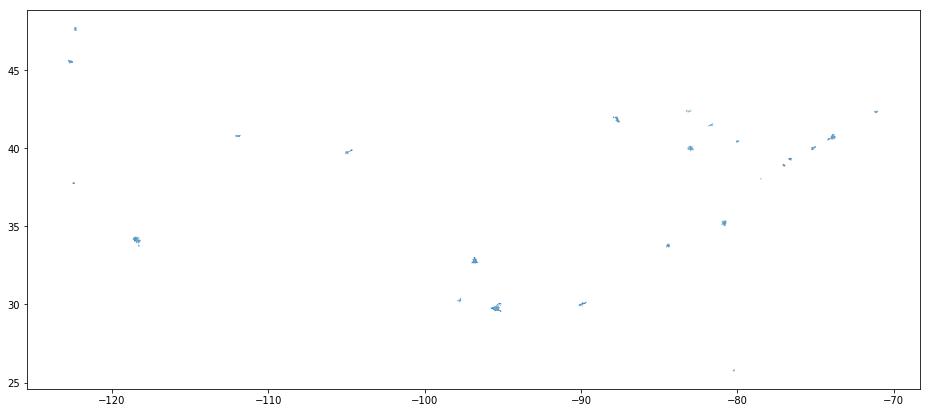

In [21]:
mega_map.plot(figsize=(16,16))